## Install the PGR-TK package

If neccessary, install the package into your python environment 
```
pip install --force /code/pgrtk-0.3.2-cp38-cp38-linux_x86_64.whl
```

In [4]:
import pgrtk
import os
import matplotlib.pyplot as plt
from IPython.display import SVG
%matplotlib inline

In [5]:
pgrtk.__version__

'pgrtk 0.3.3 (main:d256c5f, release build, linux [x86_64] [rustc 1.62.0 (a8314ef7d 2022-06-27)])'

In [6]:
os.chdir("/results")

## Lazy load the the AGCfile for fetching sequences## Load the hg19 reference into `ref_seq`

In [7]:
ref_db =pgrtk.AGCFile("/data/pgr-tk-HGRP-y1-evaluation-set-v0.agc")

## Load the index into memory
The loads the index into the memory. It takes about one minute.

In [8]:
%%time
sdb = pgrtk.SeqIndexDB()
sdb.load_from_agc_index("/data/pgr-tk-HGRP-y1-evaluation-set-v0")


CPU times: user 19.4 s, sys: 1min 1s, total: 1min 21s
Wall time: 1min 21s


We can see the specification about how SHIMMERs are computed using the `get_shmmr_spec()` method. 

In [9]:
sdb.get_shmmr_spec() # window_size, k_mer_size, hieraical_reduction_factor, min_span, use_k_mer_sketch_other_than_minimizer

(80, 56, 4, 64, False)

## Query the database with the sequence of the region

We use a copy of the annotation for IGV hg19 to look up the chromosome and locations of the gene of interest.
We can fetch the region of interest with `ref_db`. Let's fetch the whole region and do a dot plot to examine the repeat structure. 

63


(0.0, 135093.0)

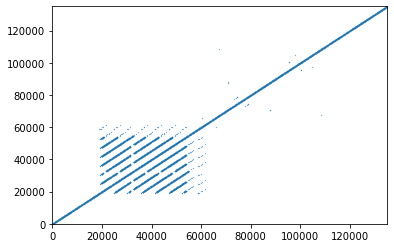

In [10]:
ref_file_name, roi_chr, roi_b, roi_e = 'hg19_tagged.fa', 'chr6_hg19', 160952514, 161087407
padding = 100
roi_len = roi_e - roi_b
#get a segment of a reference
roi_seq = ref_db.get_sub_seq(ref_file_name, roi_chr, roi_b-padding, roi_e+padding)
roi_seq = pgrtk.rc_byte_seq(roi_seq)
x, y = pgrtk.get_shmmr_dots(roi_seq, roi_seq, 32, 32, 2, 2)
plt.plot(x, y, ".", markersize=0.5)
print(x[0])
plt.xlim(0,len(roi_seq))
plt.ylim(0,len(roi_seq))

In [11]:
#find hits in the pangenomic reference
aln_range = pgrtk.query_sdb(sdb, roi_seq, merge_range_tol=100000)

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 106
The total aligned regions is 106


We can examine, the target region sizes.

In [12]:
rgn_lengths = []
for k in list(aln_range.keys()):
    b, e = aln_range[k][0][0:2]
    print(sdb.seq_info[k], "target region", b, "-", e, "len:", e-b )
    rgn_lengths.append(e-b)

('HG03453#2#JAGYVV010000137.1', 'HG03453.maternal.f1_assembly_v2_genbank.fa', 6415337) target region 4883032 - 5062938 len: 179906
('NA21309#1#JAHEPC010000374.1', 'NA21309.paternal.f1_assembly_v2_genbank.fa', 1225436) target region 942 - 14605 len: 13663
('HG00735#1#JAHBCH010000011.1', 'HG00735.paternal.f1_assembly_v2_genbank.fa', 102288089) target region 100732318 - 100940460 len: 208142
('HG01123#2#JAGYYY010000009.1', 'HG01123.maternal.f1_assembly_v2_genbank.fa', 103078045) target region 10092490 - 10339734 len: 247244
('HG02109#1#JAHEPG010000154.1', 'HG02109.paternal.f1_assembly_v2_genbank.fa', 2902882) target region 2831 - 138567 len: 135736
('HG03486#1#JAHEOQ010000122.1', 'HG03486.paternal.f1_assembly_v2_genbank.fa', 6444572) target region 1356581 - 1542031 len: 185450
('HG01358#2#JAGYZA010000101.1', 'HG01358.maternal.f1_assembly_v2_genbank.fa', 10246933) target region 10099309 - 10245241 len: 145932
('HG02055#2#JAHEPJ010000107.1', 'HG02055.maternal.f1_assembly_v2_genbank.fa', 641

Text(0, 0.5, 'count')

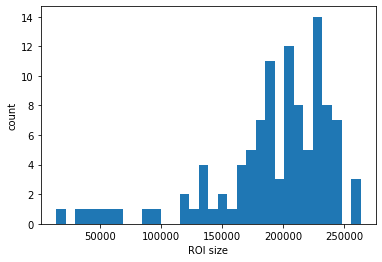

In [13]:
plt.hist(rgn_lengths, bins=32);
plt.xlabel("ROI size")
plt.ylabel("count")

Some mapped regions are larger, let's check the repeat / CNV by quick dot plots. We label the region of the ROI by two vertical grey lines. We observe that there are different number of intersections (~different copy number of the ROI) of the region the "dots" due to the different repeat structures.

In [14]:
seq_list = []
i = 1
plt.figure(figsize=(24, 24))
for k in list(aln_range.keys()):
    ctg_name, source, _ = sdb.seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()

    rgns = pgrtk.merge_regions(rgns, tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
        aln.sort()
  
        if aln[0][0][0] > padding or aln[-1][0][1] < padding + roi_len:
            continue
        
        #for illustration purpose, we only plot with the sequnce spanned through the whole region

        #if e-b < 0.75 * (roi_len + 2 * padding):             
        #    continue

        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
  
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)

        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        x, y = pgrtk.get_shmmr_dots(roi_seq, seq, 32, 32, 1, 1)
        
        
        if i <= 36:
            plt.subplot(6,6,i)
            plt.plot(x, y, ".", markersize=0.1)
            plt.plot([padding, padding],[0, max(y)], color='grey')
            plt.plot([padding+roi_len, padding+roi_len],[0, max(y)], color='grey')
        i += 1
        
        
        
        

<Figure size 1728x1728 with 0 Axes>

## Create a new shimmer database for the detailed study

In [15]:
seq_list = []
seq_info = sdb.seq_info.copy()
i = 0
for k in list(aln_range.keys()):
    ctg_name, source, _ = seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()
    
    rgns = pgrtk.merge_regions(rgns,tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
        
        #for illustration purpose, we only plot with the sequnce spanned through the whole region

        if e-b < 0.75 * (roi_len + 2 * padding):             
            continue
            
        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)
  
        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        
        i += 1



Create a shimmer indext database with smaller window (denser shimmers)

In [16]:
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=6, min_span=18)

In [17]:
len(new_sdb.seq_info)

98

In [18]:
#find hits in the pangenomic reference
aln_range0 = pgrtk.query_sdb(new_sdb, roi_seq, merge_range_tol=300000)

aln_range = aln_range0

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 98
The total aligned regions is 98


Let's loop through the hits (contigs that has alignments) and see the number of "copies".

In [19]:
from collections import Counter

In [20]:
n_copy = {}
for k in list(aln_range.keys()):
    n_copy[k] = len(aln_range[k])
copy_count = Counter(n_copy.values())
for nc, nh in copy_count.items():
    print("number of copy: {}, number of haplotypes: {}".format(nc, nh))

number of copy: 1, number of haplotypes: 98


Text(0, 0.5, 'count')

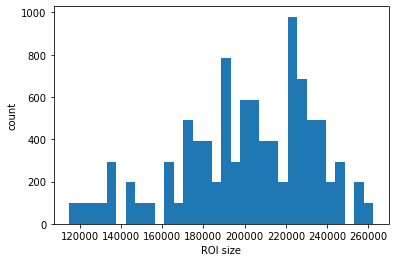

In [21]:
rgn_lengths = []
for k in list(aln_range.keys()):
    for sid, rgns in aln_range.items():
        for rgn in rgns:
            b, e = rgn[0:2]
            #print(seq_index[k], "target region", b, "-", e, "len:", e-b )
            rgn_lengths.append(e-b)
plt.hist(rgn_lengths, bins=32);
plt.xlabel("ROI size")
plt.ylabel("count")

In [22]:
f0 = open("/results/ROI_seq.fa", "w")
for ctg, seq in seq_list:
    
    print(">{}".format(ctg), file=f0)
    print(pgrtk.u8_to_string(seq), file=f0)
       
f0.close()

In [23]:
help(new_sdb.generate_mapg_gfa)

Help on built-in function generate_mapg_gfa:

generate_mapg_gfa(...) method of builtins.SeqIndexDB instance
    Convert the adjecent list of the shimmer graph shimmer_pair -> GFA
    
    Parameters
    ----------
    min_count : int
        the minimum number of times a pair of shimmers must be observed to be included in the graph
    
    filenpath : string
        the path to the output file
    
    Returns
    -------
    
    None
        The data is written into the file at filepath



In [24]:
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=6, min_span=18)
new_sdb.generate_mapg_gfa(0, "/results/ROI_80_56_6.gfa")

new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=2, min_span=18)
new_sdb.generate_mapg_gfa(0, "/results/ROI_80_56_2.gfa")

## Construct the genome graphs

In [25]:
import networkx as nx
from networkx.drawing import nx_pydot 

In [26]:
def get_graph(seq_list, w=128, k=56, r=4, min_span=28, highlite=0):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=min_span)
    new_sdb.generate_mapg_gfa(0, f"/results/{name}-{w}-{k}-{r}.gfa")
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        #if sid != 45:
        #    continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            penwidth =  2 + 0.1 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = penwidth, color="orange" )
            G.add_edge(w, v, penwidth = penwidth, color="orange" )
            G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
            
    node_to_sid = {}
    for v in G.nodes():
        node_to_sid.setdefault(v, {})
        for sid, path in sid_to_path.items():
            node_to_sid[v][sid] = 0
            
     
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        for v in path:
            v = tuple(v[-2:])
            node_to_sid[v][sid] = 1
    #nx.set_node_attributes(G, node_to_sid)  
    return G
    

In [27]:
def get_graph2(seq_list, w=128, k=56, r=4, min_span=28, highlite=0):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=min_span)
    new_sdb.generate_mapg_gfa(0, f"/results/{name}-{w}-{k}-{r}.gfa")
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        #if sid != 45:
        #    continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            penwidth =  1 + 0.02 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = penwidth, color="orange" )
            G.add_edge(w, v, penwidth = penwidth, color="orange" )
            G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
            
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        if sid != highlite:
            continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "blue"
            penwidth =  1 + 0.02 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_node(v, fillcolor=color, style="filled")
            G.add_edge(v, w, penwidth = penwidth, color=color )
            G.add_edge(w, v, penwidth = penwidth, color=color )
            v = w
    return G
    

## Generate Repeat Pattern Using the Principal Bundles

In [28]:
import numpy as np

In [29]:
shmmrspec = {"w": 56, "k":56, "r":1, "min_span":0 }
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, 
                           w = shmmrspec["w"], 
                           k = shmmrspec["k"], 
                           r = shmmrspec["r"], 
                           min_span = shmmrspec["min_span"])

In [30]:
principal_bundles, sid_smps = new_sdb.get_principal_bundle_decomposition(0,8)
sid_to_smps = dict(sid_smps)
print(len(principal_bundles))

100


In [31]:
import numpy as np
from matplotlib import cm

In [32]:
cmap=plt.get_cmap("nipy_spectral")
cmap

In [33]:
lpb = len(principal_bundles)
color_theme0 = cmap(np.linspace(0.1, 0.9, lpb))
#pseudo-randomize the colors
idx = np.array([_ * (lpb+8011) for _ in range(lpb)]) % lpb
print(idx)
color_theme = color_theme0[idx]

[ 0 11 22 33 44 55 66 77 88 99 10 21 32 43 54 65 76 87 98  9 20 31 42 53
 64 75 86 97  8 19 30 41 52 63 74 85 96  7 18 29 40 51 62 73 84 95  6 17
 28 39 50 61 72 83 94  5 16 27 38 49 60 71 82 93  4 15 26 37 48 59 70 81
 92  3 14 25 36 47 58 69 80 91  2 13 24 35 46 57 68 79 90  1 12 23 34 45
 56 67 78 89]


In [34]:
b_vertex_to_position = {}
i = 0
for bundle in principal_bundles:
    for v in bundle[2]:
        vertex = tuple(v[:2])
        b_vertex_to_position[vertex] = i, bundle[0]
        i += 1

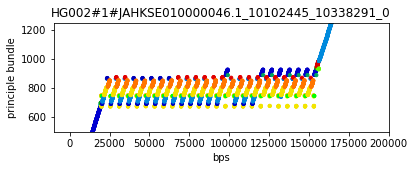

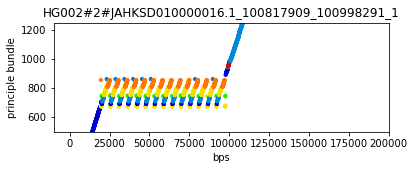

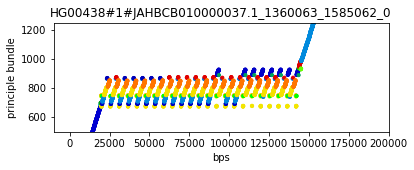

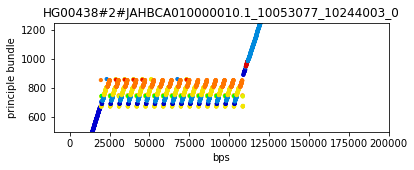

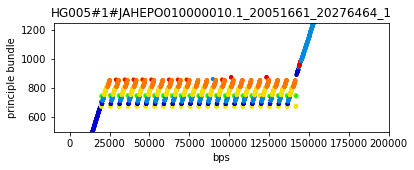

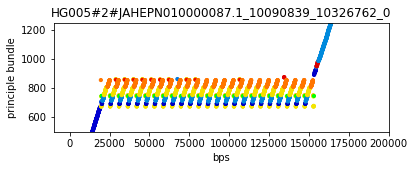

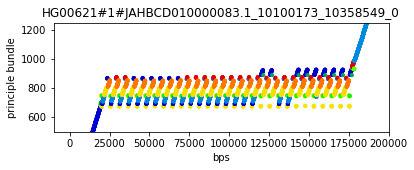

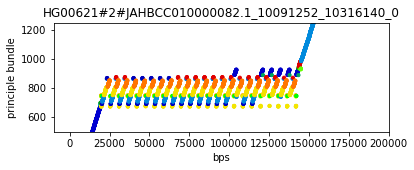

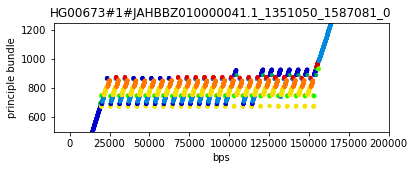

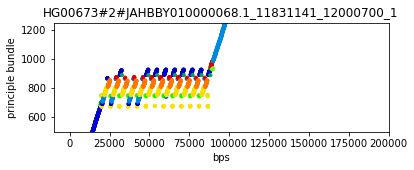

In [35]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

#fig = plt.figure(figsize=(24,96))
pidx = 1
for sid, data in sinfo[:10]:
    ctg, _, _ = data
    smps = sid_to_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    #track0_x = []
    #track0_c = []
    #matches = set([(_[0], _[1]) for _ in gene_matches[sid]])
    for s in smps:
        if s[1] is None:
            continue
        vertex = tuple(s[0][:2])
        x.append(s[0][2])
        y.append(b_vertex_to_position[vertex][0]) # same direction
        c.append(color_theme[s[1][0]])
            

    fig = plt.figure(figsize=(6,2))
    plt.scatter(x, y, marker=".", color=c, s=40)
    
    
    plt.xlim(-10000,200000)
    plt.ylim(500,1250)
    plt.title(ctg)
    plt.xlabel("bps")
    plt.ylabel("principle bundle")
    

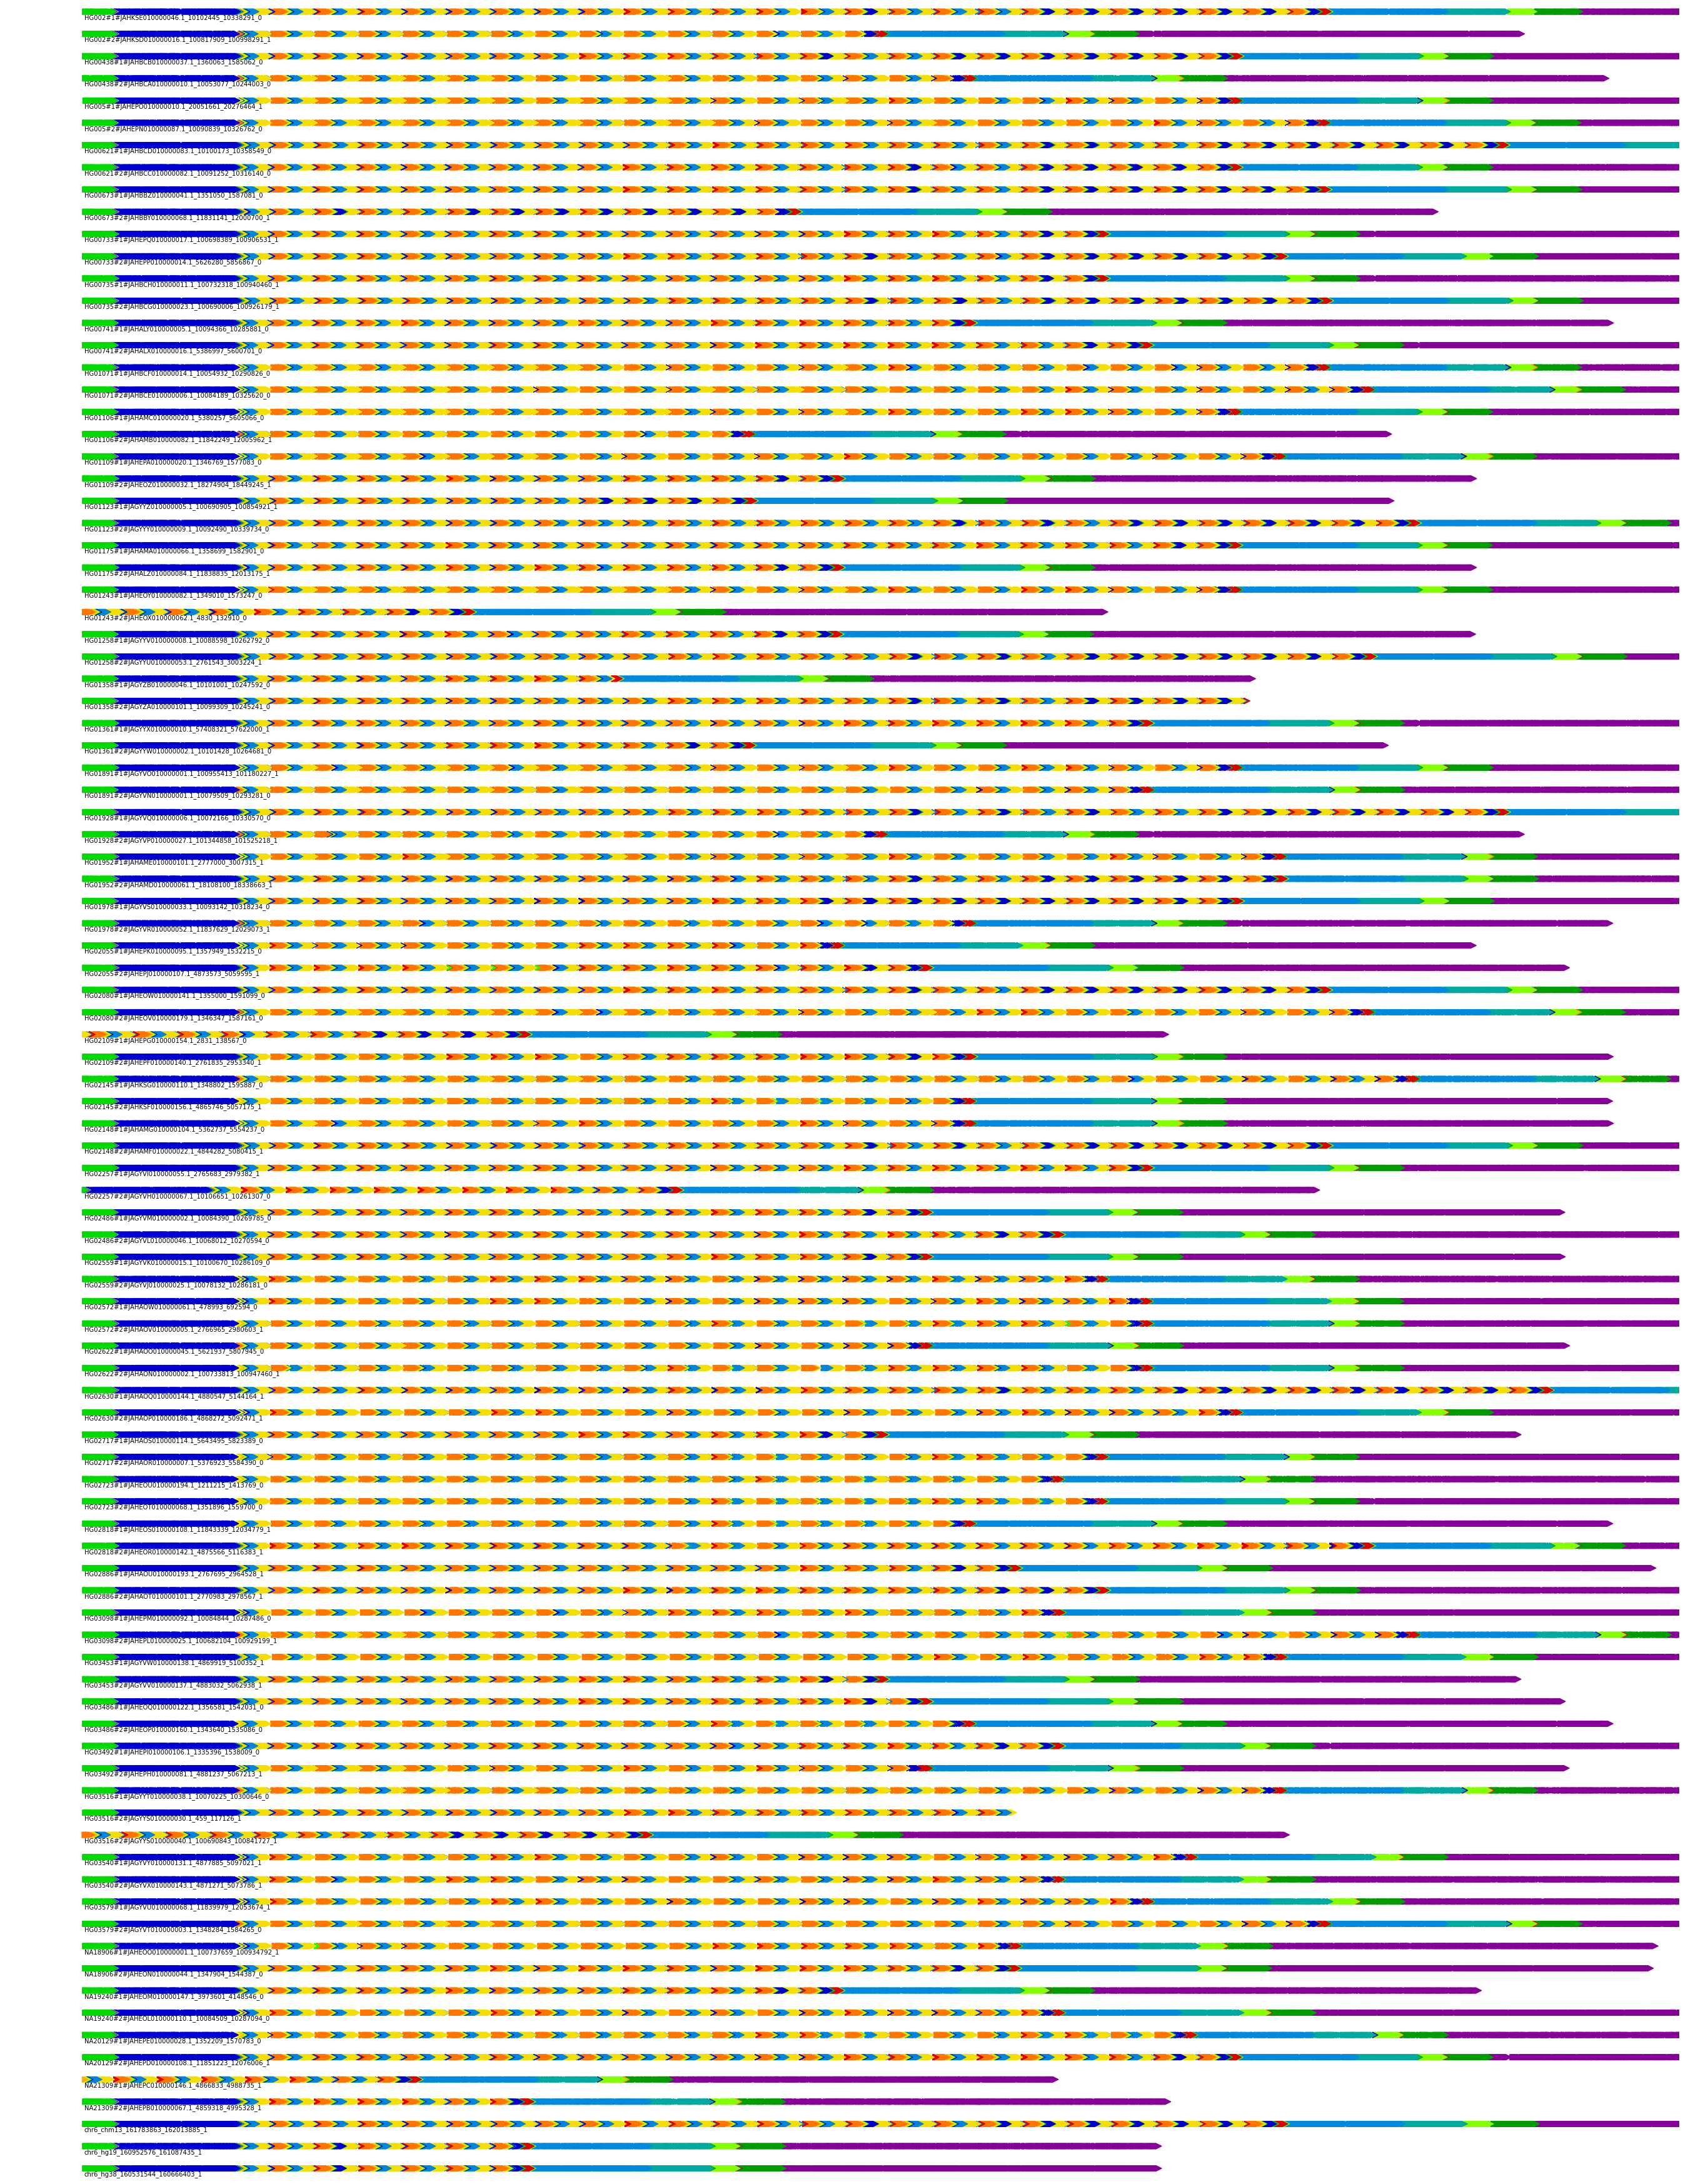

In [36]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

fig = plt.figure(figsize=(48,64))
pidx = 1
for sid, data in sinfo:
    ctg, _, _ = data
    smps = sid_to_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    track0_x = []
    track0_c = []
  
    for s in smps:
        if s[1] is None:
            continue
        
        if s[0][4] == s[1][1]:
            x.append(s[0][2])
            y.append(0) # same direction
            c.append(color_theme[s[1][0]])
        else:
            rx.append(s[0][2])
            ry.append(6)
            rc.append(color_theme[s[1][0]])
        # if tuple(s[0][2:4]) in matches:
        #     track0_x.append(s[0][2])
        #     track0_c.append(fcolors[s[1][0]])
            
    y = np.array(y) 
    ry = np.array(ry)
    x.reverse()
    c.reverse()
    
    plt.subplot(len(sid_smps), 1, pidx)

    pidx += 1
    plt.scatter(x, y, marker=">", color=c, s=80)
    plt.scatter(rx, ry, marker="<", color=rc, s=80)
    
    
    plt.axis("off")
    plt.ylim(-12,8)
    plt.xlim(-10000,200000)
    plt.text(0, -8, ctg)

## PCA Analysis

In [37]:
from sklearn.decomposition import PCA

In [38]:
sample2eth = {}
with open("/code/HPRC_y1_ethnic.csv") as f:
    for r in f:
        r = r.strip().split()
        sample2eth[r[0]] = r[2]

In [39]:
bundle_id_count = []
for sid, data in sinfo:
    smps = sid_to_smps[sid]
    for s in smps:
        if s[1] is not None:
            bundle_id_count.append(s[1][0])
bundle_id_count = Counter(bundle_id_count)

In [40]:
repeat_bundles = set()
for bid, count in bundle_id_count.items():
    if count/len(principal_bundles[bid]) > 97 * 2.5:
        repeat_bundles.add(bid)

In [41]:
s_vectors = np.zeros( (len(sid_to_smps), len(b_vertex_to_position)))

ctg_labels = [""]*len(sid_to_smps)


for sid, smps in sid_to_smps.items(): 
    ctg, src, _ = seq_info[sid]
    for smp, bundle_id in smps:
        if bundle_id is None:
            continue
        node = smp[0], smp[1]
        direction = smp[4]

        if node in b_vertex_to_position:
            if b_vertex_to_position[node][1] not in repeat_bundles:
                continue
            s_vectors[sid, b_vertex_to_position[node][0]] += 1
    ctg_labels[sid]=ctg

s_vectors = np.array(s_vectors)
s_vectors = s_vectors[:,710:860]

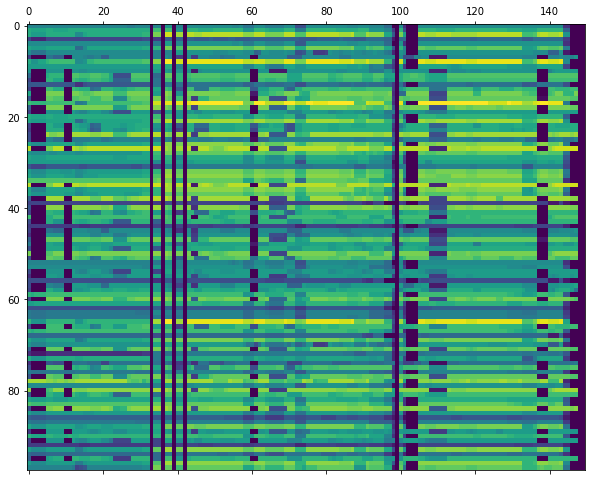

In [42]:
plt.figure(figsize=(10,8))
plt.matshow(s_vectors, fignum=1,  aspect='auto')

In [43]:
eths = []
for c in ctg_labels:
    #print(c, sample2eth.get(c.split("#")[0], "NA"))
    eths.append(sample2eth.get(c.split("#")[0], "NA"))

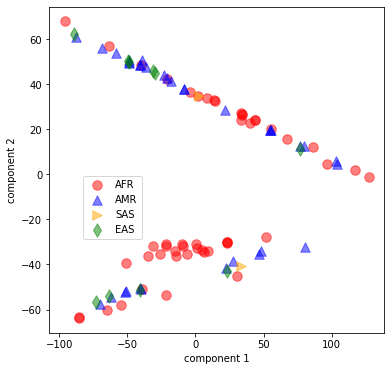

In [44]:
pca = PCA(n_components=2)
comp = pca.fit_transform(s_vectors)

[x, y] = zip( *[ (_[0], _[1]) for _ in comp ] )
c_map = {"AFR":"red", "AMR": "blue", "SAS": "orange", "EAS":"green" }
m_map = {"AFR":"o", "AMR": "^", "SAS": ">", "EAS":"d" }
colors = []

ax=plt.figure(figsize=(6,6))
for eth, color in c_map.items():
    xx = []
    yy = []
    for i in range(len(x)):
        #plt.text(x[i], y[i], eths[i])
        if eths[i] != eth:
            continue
        xx.append(x[i])
        yy.append(y[i])
    plt.scatter(xx, yy, alpha=0.5, marker=m_map[eth], c=color, s=90, label=eth)

ax.legend(bbox_to_anchor=(0.350, 0.5), loc="upper right")

plt.xlabel("component 1")
plt.ylabel("component 2")
    
pca_x = x[:]
pca_y = y[:]

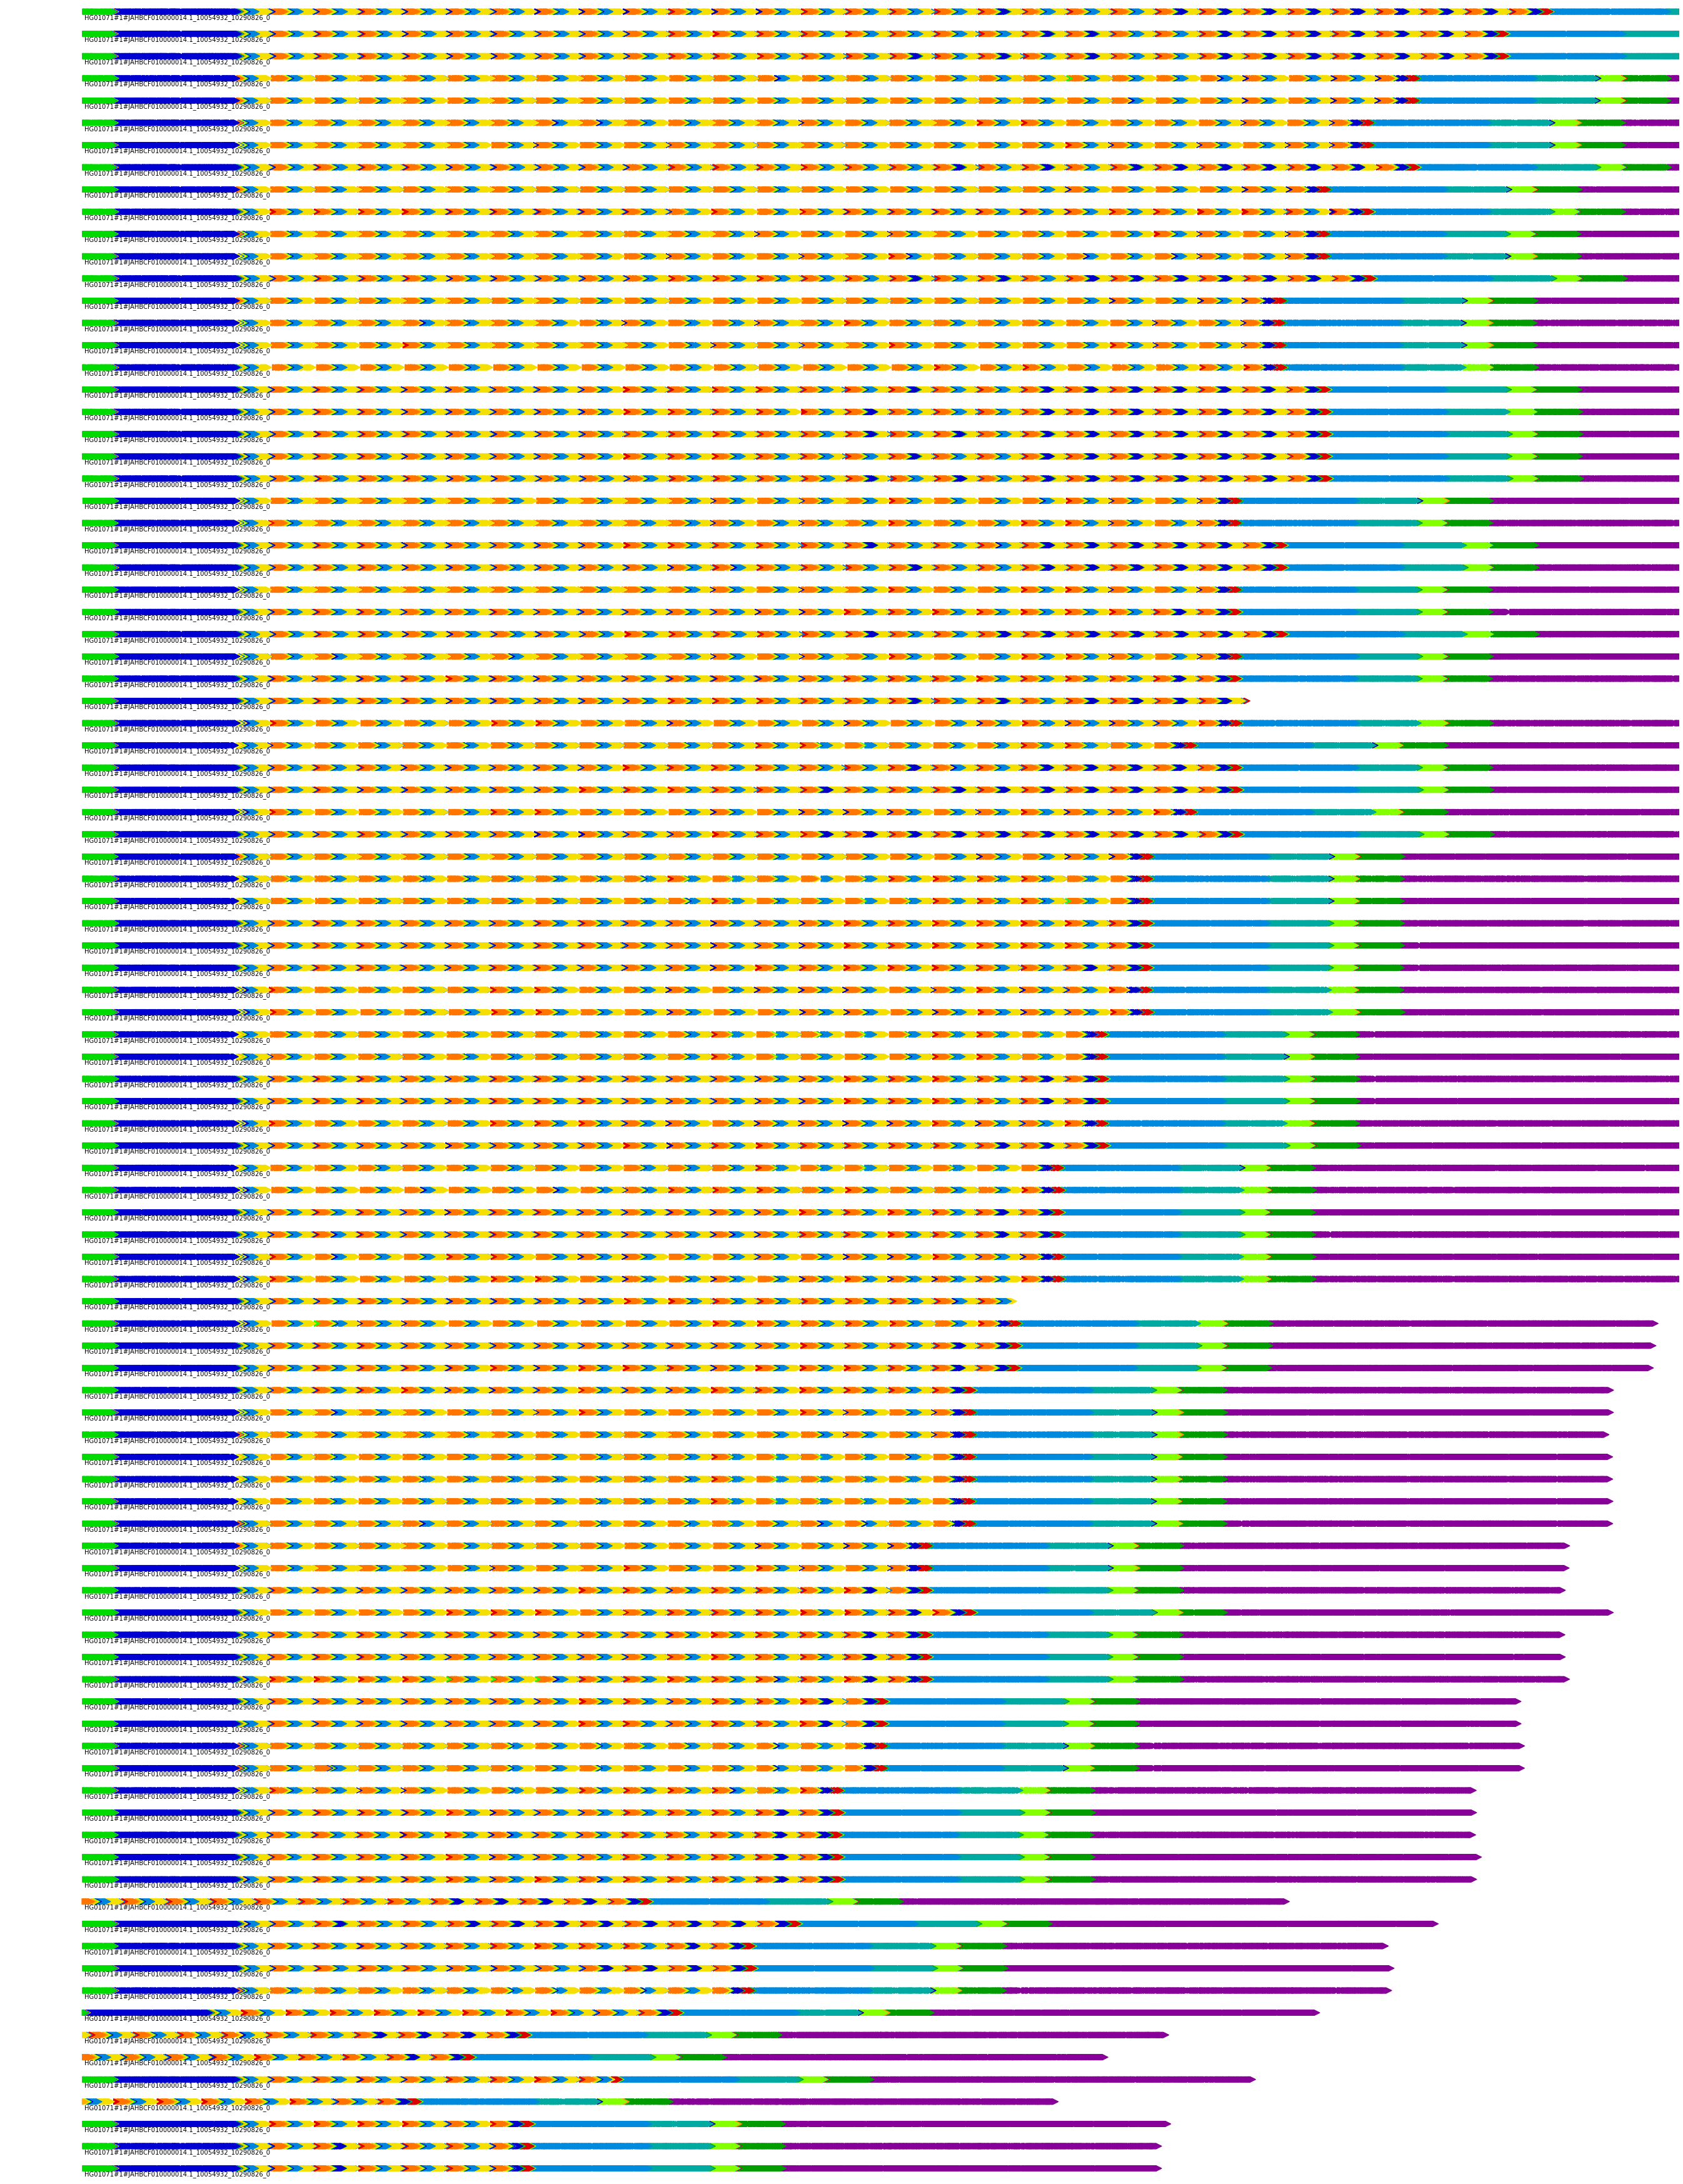

In [45]:
seq_info = new_sdb.seq_info.copy()
#plt.figure(figsize=(24,96))
plt.figure(figsize=(48,64))
pidx = 1

for yy, sid in sorted([(_[1],_[0]) for _ in enumerate(pca_x)]):
    
    smps = sid_to_smps[sid]

    x, rx = [], []
    y, ry = [], []
    c, rc = [], []

  
    for s in smps:
        if s[1] is None:
            continue
        
        if s[0][4] == s[1][1]:
            x.append(s[0][2])
            y.append(0) # same direction
            c.append(color_theme[s[1][0]])
        else:
            rx.append(s[0][2])
            ry.append(6)
            rc.append(color_theme[s[1][0]])

    y = np.array(y) 
    ry = np.array(ry)
    x.reverse()
    c.reverse()
    
    plt.subplot(len(pca_y), 1, pidx)

    pidx += 1
    
    plt.scatter(x, y, marker=">", color=c, s=80)
    plt.scatter(rx, ry, marker="<", color=rc, s=80)
    
    plt.axis("off")
    plt.ylim(-12,8)
    plt.xlim(-10000,200000)
    plt.text(0, -8, ctg)